In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import datetime
import time
import os
import json
from skimage.transform import resize

from src.data import NSynth
from src.utils import print_and_log
from src.models import VAE

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [3]:
hparams = {
    'checkpoint' : None,
    'instrument_source' : [0, 1, 2],
    'sample_rate' : 16000,
    'n_samples' : 64000,
    'feature_type' : 'mel',
    'random_crop' : True,
    'resize' : None,
    'normalize' : True,
    'standardize' : True,
    'standardize_mean' : 0.3356,
    'standardize_std' : 0.2212,
    'spec_augment' : False,
    'remove_synth_lead' : True,
    'n_samples_per_class' : None,
    'depths' : (32, 64, 128, 128, 256, 256, 512), 
    'kl_loss_weight' : 0.001,
    'n_epochs' : 50,
    'batch_size' : 32,
    'lr' : 0.0001,
    'hidden_dim' : 1024,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = NSynth(
    'data/nsynth', 
    'train',
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    spec_augment=hparams['spec_augment'],
    remove_synth_lead=hparams['remove_synth_lead'], 
    n_samples_per_class=hparams['n_samples_per_class']
)

val_dataset = NSynth(
    'data/nsynth', 
    'val',
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    remove_synth_lead=hparams['remove_synth_lead']
)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [6]:
model = VAE(
    h_dim=hparams['hidden_dim'], 
    sigmoid=(not hparams['standardize']),
    depths=hparams['depths']
).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 10530049


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [8]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/vae/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{} {}'.format(train_dataset.__class__.__name__, model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

NSynth VAE
checkpoint : None
instrument_source : [0, 1, 2]
sample_rate : 16000
n_samples : 64000
feature_type : mel
random_crop : True
resize : None
normalize : True
standardize : True
standardize_mean : 0.3356
standardize_std : 0.2212
spec_augment : False
remove_synth_lead : True
n_samples_per_class : None
kl_loss_weight : 0.001
n_epochs : 50
batch_size : 32
lr : 0.0001
hidden_dim : 1024
display_iters : 100
val_iters : 1000
n_val_samples : 1000
n_early_stopping : 5


[0,     1] loss : (total : 6.8185, recon : 6.5544, kl : 264.0381)
[0,   100] loss : (total : 0.8441, recon : 0.7062, kl : 137.8908)
[0,   200] loss : (total : 0.4529, recon : 0.3869, kl : 66.0063)
[0,   300] loss : (total : 0.3305, recon : 0.2856, kl : 44.8392)
[0,   400] loss : (total : 0.3102, recon : 0.2659, kl : 44.3689)
[0,   500] loss : (total : 0.3862, recon : 0.3388, kl : 47.3302)
[0,   600] loss : (total : 0.2992, recon : 0.2637, kl : 35.4633)
[0,   700] loss : (total : 0.3300, recon : 0.2881, kl : 41.8907)
[0,   800] loss : (total : 0.2975, recon : 0.2498, kl : 47.7369)
[0,   900] loss : (total : 0.2743, recon : 0.2317, kl : 42.5955)
[0,  1000] loss : (total : 0.4239, recon : 0.3813, kl : 42.6124)
[0,  1100] loss : (total : 0.3142, recon : 0.2757, kl : 38.5293)
[0,  1200] loss : (total : 0.3161, recon : 0.2813, kl : 34.7993)
[0,  1300] loss : (total : 0.3191, recon : 0.2779, kl : 41.1409)
[0,  1400] loss : (total : 0.2335, recon : 0.1950, kl : 38.4751)
[0,  1500] loss : (tota

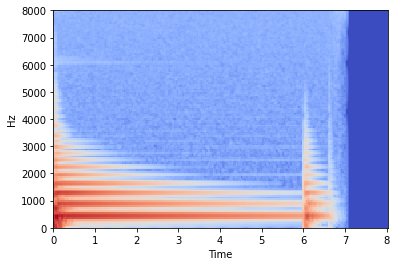

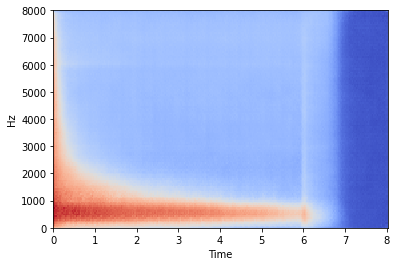

Weights saved in train_results/vae/20200806-175812/model-8866.weights
[1,  8900] loss : (total : 0.2310, recon : 0.1951, kl : 35.8489)
[1,  9000] loss : (total : 0.2253, recon : 0.1881, kl : 37.1363)
[1,  9100] loss : (total : 0.2133, recon : 0.1640, kl : 49.2778)
[1,  9200] loss : (total : 0.2365, recon : 0.2004, kl : 36.1483)
[1,  9300] loss : (total : 0.3165, recon : 0.2628, kl : 53.6881)
[1,  9400] loss : (total : 0.2335, recon : 0.1857, kl : 47.8100)
[1,  9500] loss : (total : 0.2660, recon : 0.2201, kl : 45.9441)
[1,  9600] loss : (total : 0.2092, recon : 0.1708, kl : 38.4346)
[1,  9700] loss : (total : 0.1936, recon : 0.1520, kl : 41.5454)
[1,  9800] loss : (total : 0.1776, recon : 0.1341, kl : 43.5835)
[1,  9900] loss : (total : 0.2301, recon : 0.1926, kl : 37.4800)
[1, 10000] loss : (total : 0.1893, recon : 0.1485, kl : 40.7981)
[1, 10100] loss : (total : 0.1909, recon : 0.1544, kl : 36.4909)
[1, 10200] loss : (total : 0.2183, recon : 0.1675, kl : 50.7791)
[1, 10300] loss : (t

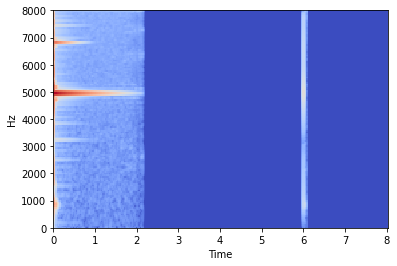

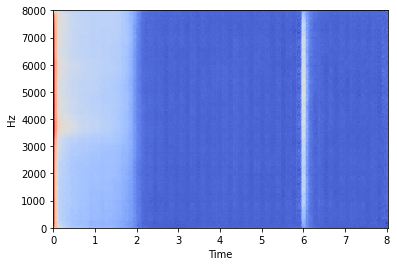

Weights saved in train_results/vae/20200806-175812/model-17732.weights
[2, 17800] loss : (total : 0.2042, recon : 0.1548, kl : 49.3857)
[2, 17900] loss : (total : 0.2035, recon : 0.1615, kl : 41.9936)
[2, 18000] loss : (total : 0.1881, recon : 0.1481, kl : 39.9955)
[2, 18100] loss : (total : 0.1688, recon : 0.1261, kl : 42.7389)
[2, 18200] loss : (total : 0.1767, recon : 0.1347, kl : 41.9806)
[2, 18300] loss : (total : 0.1818, recon : 0.1435, kl : 38.3001)
[2, 18400] loss : (total : 0.2066, recon : 0.1423, kl : 64.2711)
[2, 18500] loss : (total : 0.2074, recon : 0.1606, kl : 46.8536)
[2, 18600] loss : (total : 0.1675, recon : 0.1221, kl : 45.4677)
[2, 18700] loss : (total : 0.2123, recon : 0.1646, kl : 47.6432)
[2, 18800] loss : (total : 0.1788, recon : 0.1399, kl : 38.9858)
[2, 18900] loss : (total : 0.1739, recon : 0.1219, kl : 51.9675)
[2, 19000] loss : (total : 0.2278, recon : 0.1593, kl : 68.4989)
[2, 19100] loss : (total : 0.1872, recon : 0.1473, kl : 39.8600)
[2, 19200] loss : (

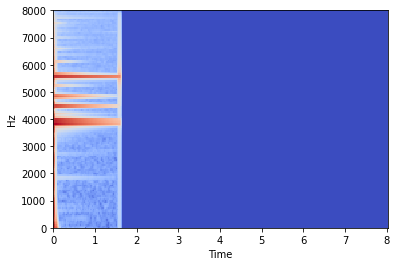

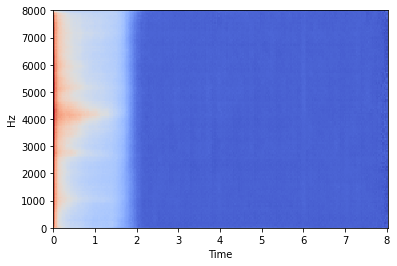

Weights saved in train_results/vae/20200806-175812/model-26598.weights
[3, 26600] loss : (total : 0.1575, recon : 0.1155, kl : 42.0102)
[3, 26700] loss : (total : 0.1996, recon : 0.1543, kl : 45.3049)
[3, 26800] loss : (total : 0.1635, recon : 0.1204, kl : 43.0815)
[3, 26900] loss : (total : 0.1654, recon : 0.1269, kl : 38.4725)
[3, 27000] loss : (total : 0.2338, recon : 0.1626, kl : 71.2209)
[3, 27100] loss : (total : 0.1615, recon : 0.1216, kl : 39.8242)
[3, 27200] loss : (total : 0.1857, recon : 0.1411, kl : 44.5735)
[3, 27300] loss : (total : 0.1671, recon : 0.1256, kl : 41.5623)
[3, 27400] loss : (total : 0.1833, recon : 0.1179, kl : 65.4686)
[3, 27500] loss : (total : 0.1873, recon : 0.1446, kl : 42.7362)
[3, 27600] loss : (total : 0.1817, recon : 0.1398, kl : 41.8253)
[3, 27700] loss : (total : 0.1826, recon : 0.1373, kl : 45.2304)
[3, 27800] loss : (total : 0.1858, recon : 0.1426, kl : 43.2081)
[3, 27900] loss : (total : 0.1677, recon : 0.1191, kl : 48.5793)
[3, 28000] loss : (

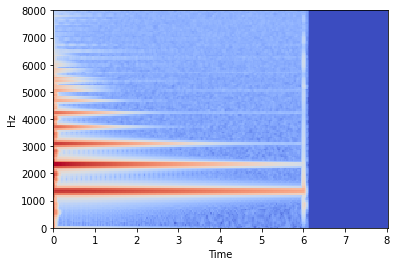

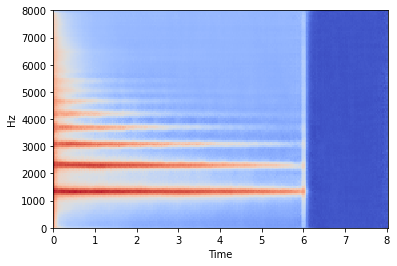

Weights saved in train_results/vae/20200806-175812/model-35464.weights
[4, 35500] loss : (total : 0.1818, recon : 0.1377, kl : 44.0621)
[4, 35600] loss : (total : 0.1571, recon : 0.1205, kl : 36.6397)
[4, 35700] loss : (total : 0.1646, recon : 0.1227, kl : 41.8661)
[4, 35800] loss : (total : 0.1488, recon : 0.1095, kl : 39.2892)
[4, 35900] loss : (total : 0.1704, recon : 0.1278, kl : 42.5626)
[4, 36000] loss : (total : 0.1367, recon : 0.0952, kl : 41.5111)
[4, 36100] loss : (total : 0.1640, recon : 0.1227, kl : 41.2492)
[4, 36200] loss : (total : 0.1670, recon : 0.1183, kl : 48.6419)
[4, 36300] loss : (total : 0.1811, recon : 0.1387, kl : 42.4582)
[4, 36400] loss : (total : 0.1495, recon : 0.1078, kl : 41.6682)
[4, 36500] loss : (total : 0.1578, recon : 0.1133, kl : 44.4464)
[4, 36600] loss : (total : 0.1238, recon : 0.0862, kl : 37.6381)
[4, 36700] loss : (total : 0.1774, recon : 0.1241, kl : 53.3051)
[4, 36800] loss : (total : 0.1513, recon : 0.1061, kl : 45.2296)
[4, 36900] loss : (

In [ ]:
if hparams['standardize']:
    recon_loss_fn = nn.MSELoss()
else:
    recon_loss_fn = nn.BCELoss()
    
kl_loss_fn = lambda mu, log_var : torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim=0)

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.to(device)
        outputs, mu, log_var = model(batch)
        
        recon_loss = recon_loss_fn(outputs, batch)
        kl_loss = kl_loss_fn(mu, log_var)
        loss = recon_loss + hparams['kl_loss_weight']*kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f})'\
                          .format(epoch, itr, loss.item(), recon_loss.item(), kl_loss.item()), log_file)
            
    # validation
    model.eval()
    with torch.no_grad():
        ct, i, val_loss, val_recon_loss, val_kl_loss = 0, 0, 0.0, 0.0, 0.0
        for batch in val_dataloader:
            i += 1
            ct += batch.size(0)
            batch = batch.to(device)
            outputs, mu, log_var = model(batch)

            recon_loss = recon_loss_fn(outputs, batch)
            kl_loss = kl_loss_fn(mu, log_var)
            loss = recon_loss + hparams['kl_loss_weight']*kl_loss
            
            val_recon_loss += (recon_loss.item() - val_recon_loss)/i
            val_kl_loss += (kl_loss.item() - val_kl_loss)/i
            val_loss += (loss.item() - val_loss)/i

            if ct >= hparams['n_val_samples']:
                break

    print_and_log('Val - loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f})'\
                  .format(val_loss, val_recon_loss, val_kl_loss), log_file)
    
    librosa.display.specshow(batch[0][0].cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()
    librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()

    if val_loss < best_loss:
        since_best = 0
        best_loss = val_loss

        # save weights
        ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
        torch.save(model.state_dict(), ckpt_weights_path)
        print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)

        # save meta information
        ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
        torch.save({
            'best_loss' : best_loss,
            'epoch' : epoch,
            'itr' : itr,
            'optimizer' : optimizer.state_dict(),
            'model' : model.state_dict()
        }, ckpt_meta_path)
    else:
        since_best += 1
        if since_best >= hparams['n_early_stopping']:
            done = True
            print_and_log('Early stopping... training complete', log_file)

    model.train()